# Table of Contents
 <p><div class="lev1"><a href="#VAE+GAN"><span class="toc-item-num">1&nbsp;&nbsp;</span>VAE+GAN</a></div>

# VAE+GAN

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import six
import math

from PIL import Image
from StringIO import StringIO
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import chainer.optimizers as O
import tqdm
import time
from IPython.display import display
import json

In [2]:
from vaegan import Encoder, Decoder, Discriminator, EncDec
from fauxtograph import get_paths, image_resize

In [3]:
#paths = get_paths('../../sample_images/sample_train/')
paths = get_paths('/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_resize/sample_train/')
print len(paths)

5000


In [4]:
class VAEGAN(object):
    def __init__(self, img_width=64, img_height=64, color_channels=3, encode_layers=[1000, 600, 300],
                 decode_layers=[300, 800, 1000], disc_layers=[1000, 600, 300],
                 kl_ratio=1.0, latent_width=500, flag_gpu=True, mode='convolution',
                 enc_adam_alpha=0.0002, enc_adam_beta1=0.5, 
                 dec_adam_alpha=0.0002, dec_adam_beta1=0.5,
                 disc_adam_alpha=0.0001, disc_adam_beta1=0.5,
                 rectifier='clipped_relu', dropout_ratio=0.5):
        self.img_width = img_width
        self.img_height = img_height
        self.color_channels = color_channels
        self.encode_layers = encode_layers
        self.decode_layers = decode_layers
        self.disc_layers = disc_layers
        self.kl_ratio = kl_ratio
        self.latent_width = latent_width
        self.flag_gpu = flag_gpu
        self.mode = mode
        self.enc_adam_alpha = enc_adam_alpha
        self.enc_adam_beta1 = enc_adam_beta1
        self.dec_adam_alpha = dec_adam_alpha
        self.dec_adam_beta1 = dec_adam_beta1
        self.disc_adam_alpha = disc_adam_alpha
        self.disc_adam_beta1 = disc_adam_beta1
        self.rectifier = rectifier
        self.dropout_ratio = dropout_ratio

        self.enc = Encoder(img_width=self.img_width, img_height=self.img_height, 
                           color_channels=self.color_channels, encode_layers=self.encode_layers,
                           latent_width=self.latent_width, mode=self.mode)
        self.dec = Decoder(img_width=self.img_width,img_height=self.img_height,
                           color_channels=self.color_channels, decode_layers=self.decode_layers,
                           latent_width=self.latent_width, mode=self.mode)
        self.disc = Discriminator(img_width=self.img_width, img_height=self.img_height,
                                  color_channels=self.color_channels, disc_layers=self.disc_layers,
                                  latent_width=self.latent_width, mode=self.mode)
        if self.flag_gpu:
            self.enc = self.enc.to_gpu()
            self.dec = self.dec.to_gpu()
            self.disc = self.disc.to_gpu()

        self.enc_opt = O.Adam(alpha=self.enc_adam_alpha, beta1=self.enc_adam_beta1)
        self.dec_opt = O.Adam(alpha=self.dec_adam_alpha, beta1=self.dec_adam_beta1)
        self.disc_opt = O.Adam(alpha=self.disc_adam_alpha, beta1=self.disc_adam_beta1)

    def _encode(self, data, test=False):
        x = self.enc(data, test=test)
        mean, ln_var = F.split_axis(x, 2, 1)
        samp = np.random.standard_normal(mean.data.shape).astype('float32')
        samp = Variable(samp)
        if self.flag_gpu:
            samp.to_gpu()
        z = samp * F.exp(0.5*ln_var) + mean

        return z, mean, ln_var

    def _decode(self, z, test=False):
        x = self.dec(z, test=test, rectifier=self.rectifier)

        return x

    def _forward(self, batch, test=False):

        # TrainingSetのEncodeとDecode
        encoded, means, ln_vars = self._encode(batch, test=test)
        rec = self._decode(encoded, test=test)
        normer = reduce(lambda x, y: x*y, means.data.shape) # データ数
        kl_loss = F.gaussian_kl_divergence(means, ln_vars)/normer
        #print 'means={}'.format(means.data.shape)
        #print 'ln_vars={}'.format(ln_vars.data.shape)
        #print 'kl_loss={}, normer={}'.format(kl_loss.data, normer)

        # zのサンプル
        samp_p = np.random.standard_normal(means.data.shape).astype('float32')
        z_p = chainer.Variable(samp_p)

        if self.flag_gpu:
            z_p.to_gpu()

        rec_p = self._decode(z_p)

        disc_rec, conv_layer_rec = self.disc(rec, test=test, dropout_ratio=self.dropout_ratio)

        disc_batch, conv_layer_batch = self.disc(batch, test=test, dropout_ratio=self.dropout_ratio)

        disc_x_p, conv_layer_x_p = self.disc(rec_p, test=test, dropout_ratio=self.dropout_ratio)

        dif_l = F.mean_squared_error(conv_layer_rec, conv_layer_batch)

        return kl_loss, dif_l, disc_rec, disc_batch, disc_x_p

    def transform(self, data, test=False):
        #make sure that data has the right shape.
        if not type(data) == Variable:
            if len(data.shape) < 4:
                data = data[np.newaxis]
            if len(data.shape) != 4:
                raise TypeError("Invalid dimensions for image data. Dim = %s.\
                     Must be 4d array." % str(data.shape))
            if data.shape[1] != self.color_channels:
                if data.shape[-1] == self.color_channels:
                    data = data.transpose(0, 3, 1, 2)
                else:
                    raise TypeError("Invalid dimensions for image data. Dim = %s"
                                    % str(data.shape))
            data = Variable(data)
        else:
            if len(data.data.shape) < 4:
                data.data = data.data[np.newaxis]
            if len(data.data.shape) != 4:
                raise TypeError("Invalid dimensions for image data. Dim = %s.\
                     Must be 4d array." % str(data.data.shape))
            if data.data.shape[1] != self.color_channels:
                if data.data.shape[-1] == self.color_channels:
                    data.data = data.data.transpose(0, 3, 1, 2)
                else:
                    raise TypeError("Invalid dimensions for image data. Dim = %s"
                                    % str(data.shape))

        # Actual transformation.
        if self.flag_gpu:
            data.to_gpu()
        z = self._encode(data, test=test)[0]

        z.to_cpu()

        return z.data

    def inverse_transform(self, data, test=False):
        if not type(data) == Variable:
            if len(data.shape) < 2:
                data = data[np.newaxis]
            if len(data.shape) != 2:
                raise TypeError("Invalid dimensions for latent data. Dim = %s.\
                     Must be a 2d array." % str(data.shape))
            data = Variable(data)

        else:
            if len(data.data.shape) < 2:
                data.data = data.data[np.newaxis]
            if len(data.data.shape) != 2:
                raise TypeError("Invalid dimensions for latent data. Dim = %s.\
                     Must be a 2d array." % str(data.data.shape))
        assert data.data.shape[-1] == self.latent_width,\
            "Latent shape %d != %d" % (data.data.shape[-1], self.latent_width)

        if self.flag_gpu:
            data.to_gpu()
        out = self._decode(data, test=test)

        out.to_cpu()

        if self.mode == 'linear':
            final = out.data
        else:
            final = out.data.transpose(0, 2, 3, 1)

        return final

    def load_images(self, filepaths):
        def read(fname):
            im = Image.open(fname)
            im = np.float32(im)
            return im/255.
        x_all = np.array([read(fname) for fname in tqdm.tqdm(filepaths)])
        x_all = x_all.astype('float32')
        if self.mode == 'convolution':
            x_all = x_all.transpose(0, 3, 1, 2)
        print("Image Files Loaded!")
        return x_all

    def fit(self, img_data, gamma=1.0, save_freq=-1, pic_freq=-1, n_epochs=100, batch_size=100,
            weight_decay=True,  model_path='./VAEGAN_training_model/', img_path='./VAEGAN_training_images/',
            img_out_width=10, mirroring=False):
        width = img_out_width
        self.enc_opt.setup(self.enc)
        self.dec_opt.setup(self.dec)
        self.disc_opt.setup(self.disc)

        if weight_decay:
            self.enc_opt.add_hook(chainer.optimizer.WeightDecay(0.00001))
            self.dec_opt.add_hook(chainer.optimizer.WeightDecay(0.00001))
            self.disc_opt.add_hook(chainer.optimizer.WeightDecay(0.00001))

        n_data = img_data.shape[0]

        batch_iter = list(range(0, n_data, batch_size))
        n_batches = len(batch_iter)

        c_samples = np.random.standard_normal((width, self.latent_width)).astype(np.float32)
        save_counter = 0

        df_col = ['epoch', 'enc_loss', 'dec_loss', 'dis_loss', 'GAN_loss', 'like_loss', 'prior_loss', 'L_base', 'L_rec', 'L_p']
        self.loss_buf = pd.DataFrame(columns=df_col)
        for epoch in range(1, n_epochs + 1):
            print('epoch: %i' % epoch)
            t1 = time.time()
            indexes = np.random.permutation(n_data)
            sum_l_enc = 0.
            sum_l_dec = 0.
            sum_l_disc = 0.

            sum_l_gan = 0.
            sum_l_like = 0.
            sum_l_prior = 0.
            
            sum_l_b_gan = 0.
            sum_l_r_gan = 0.
            sum_l_s_gan = 0.
            count = 0
            for i in tqdm.tqdm(batch_iter):
                x = img_data[indexes[i: i + batch_size]]
                size = x.shape[0]
                if mirroring:
                    for j in range(size):
                        if np.random.randint(2):
                            x[j, :, :, :] = x[j, :, :, ::-1]
                x_batch = Variable(x)
                zeros = Variable(np.zeros(size, dtype=np.int32))
                ones = Variable(np.ones(size, dtype=np.int32))

                if self.flag_gpu:
                    x_batch.to_gpu()
                    zeros.to_gpu()
                    ones.to_gpu()

                # kl_loss : VAE中間表現のKL正則化ロス
                # dif_l : Discriminatorの中間層出力のMSE(学習データセットと再構成画像の中間出力のMSE)
                # disc_{rec, batch, samp} : Discriminator出力(2次元)
                kl_loss, dif_l, disc_rec, disc_batch, disc_samp = self._forward(x_batch)

                # Discriminator出力のloss計算
                L_batch_GAN = F.softmax_cross_entropy(disc_batch, ones)
                L_rec_GAN = F.softmax_cross_entropy(disc_rec, zeros)
                L_samp_GAN = F.softmax_cross_entropy(disc_samp, zeros)

                l_gan = (L_batch_GAN + L_rec_GAN + L_samp_GAN)/3.
                l_like = dif_l
                l_prior = kl_loss

                enc_loss = self.kl_ratio*l_prior + l_like
                dec_loss = gamma*l_like - l_gan
                disc_loss = l_gan

                self.enc_opt.zero_grads()
                enc_loss.backward()
                self.enc_opt.update()

                self.dec_opt.zero_grads()
                dec_loss.backward()
                self.dec_opt.update()

                self.disc_opt.zero_grads()
                disc_loss.backward()
                self.disc_opt.update()

                sum_l_enc += enc_loss.data
                sum_l_dec += dec_loss.data
                sum_l_disc += disc_loss.data

                sum_l_gan += l_gan.data
                sum_l_like += l_like.data
                sum_l_prior += l_prior.data
                
                sum_l_b_gan += L_batch_GAN.data
                sum_l_r_gan += L_rec_GAN.data
                sum_l_s_gan += L_samp_GAN.data
                count += 1

                #plot_data = img_data[indexes[:width]]

            sum_l_enc /= n_batches
            sum_l_dec /= n_batches
            sum_l_disc /= n_batches
            sum_l_gan /= n_batches
            sum_l_like /= n_batches
            sum_l_prior /= n_batches
            sum_l_b_gan /= n_batches
            sum_l_r_gan /= n_batches
            sum_l_s_gan /= n_batches
            msg = "enc_loss = {0}, dec_loss = {1} , disc_loss = {2}"
            msg2 = "gan_loss = {0}, sim_loss = {1}, kl_loss = {2}"
            print(msg.format(sum_l_enc, sum_l_dec, sum_l_disc))
            print(msg2.format(sum_l_gan, sum_l_like, sum_l_prior))
            t_diff = time.time()-t1
            print("time: %f\n\n" % t_diff)
            df_tmp = pd.DataFrame([[epoch, 
                                    sum_l_enc, sum_l_dec, sum_l_disc, sum_l_gan, sum_l_like, sum_l_prior, 
                                    sum_l_b_gan, sum_l_r_gan, sum_l_s_gan]], columns=df_col)
            self.loss_buf = self.loss_buf.append(df_tmp, ignore_index=True)


In [5]:
vg = VAEGAN(img_width=96, img_height=96, flag_gpu=True)

In [6]:
# 画像ファイルのロード、正規化、transpose
x_all = vg.load_images(paths)
print 'image_data_shape = {}'.format(x_all.shape)

100%|██████████| 5000/5000 [00:08<00:00, 594.20it/s]


Image Files Loaded!
image_data_shape = (5000, 3, 96, 96)


In [7]:
vg.fit(x_all, n_epochs=100, mirroring=True)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.62961053848, dec_loss = 0.744498372078 , disc_loss = 0.625260293484
gan_loss = 0.625260293484, sim_loss = 1.36975908279, kl_loss = 0.259851694107
time: 31.017313


epoch: 2


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.1133954525, dec_loss = 0.510803818703 , disc_loss = 0.480255544186
gan_loss = 0.480255544186, sim_loss = 0.991059243679, kl_loss = 0.122336007655
time: 32.385341


epoch: 3


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.911537468433, dec_loss = 0.189314112067 , disc_loss = 0.611321628094
gan_loss = 0.611321628094, sim_loss = 0.800635755062, kl_loss = 0.110901854932
time: 32.398483


epoch: 4


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.799796462059, dec_loss = -0.0140857277438 , disc_loss = 0.710435509682
gan_loss = 0.710435509682, sim_loss = 0.696349620819, kl_loss = 0.103446811438
time: 32.373216


epoch: 5


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.857742130756, dec_loss = 0.24506162107 , disc_loss = 0.516975343227
gan_loss = 0.516975343227, sim_loss = 0.762036979198, kl_loss = 0.0957050099969
time: 32.369597


epoch: 6


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.957156538963, dec_loss = 0.689127862453 , disc_loss = 0.18524838984
gan_loss = 0.18524838984, sim_loss = 0.874376118183, kl_loss = 0.0827803909779
time: 32.407243


epoch: 7


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0239276886, dec_loss = 0.757819771767 , disc_loss = 0.184166178107
gan_loss = 0.184166178107, sim_loss = 0.94198602438, kl_loss = 0.0819414258003
time: 32.390280


epoch: 8


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.953910768032, dec_loss = 0.492435187101 , disc_loss = 0.370521992445
gan_loss = 0.370521992445, sim_loss = 0.862957000732, kl_loss = 0.0909535810351
time: 32.380814


epoch: 9


  2%|▏         | 1/50 [00:00<00:11,  4.28it/s]

enc_loss = 0.886269509792, dec_loss = 0.790421724319 , disc_loss = 0.0200900547206
gan_loss = 0.0200900547206, sim_loss = 0.81051170826, kl_loss = 0.0757579505444
time: 32.381417


epoch: 10


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.851052761078, dec_loss = 0.776275098324 , disc_loss = 0.00454844255
gan_loss = 0.00454844255, sim_loss = 0.780823528767, kl_loss = 0.0702290385962
time: 32.397012


epoch: 11


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.816106319427, dec_loss = 0.740606486797 , disc_loss = 0.00374898291193
gan_loss = 0.00374898291193, sim_loss = 0.74435544014, kl_loss = 0.0717508867383
time: 32.416662


epoch: 12


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.783740997314, dec_loss = 0.703508198261 , disc_loss = 0.00391858816147
gan_loss = 0.00391858816147, sim_loss = 0.707426846027, kl_loss = 0.0763141736388
time: 32.393680


epoch: 13


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.725823521614, dec_loss = 0.312134027481 , disc_loss = 0.326306730509
gan_loss = 0.326306730509, sim_loss = 0.638440668583, kl_loss = 0.0873828306794
time: 32.429726


epoch: 14


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.758719325066, dec_loss = -0.0366792008281 , disc_loss = 0.695927977562
gan_loss = 0.695927977562, sim_loss = 0.659248650074, kl_loss = 0.0994705408812
time: 32.421262


epoch: 15


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.727418661118, dec_loss = -0.0370162278414 , disc_loss = 0.670293867588
gan_loss = 0.670293867588, sim_loss = 0.633277714252, kl_loss = 0.0941408351064
time: 32.432003


epoch: 16


  2%|▏         | 1/50 [00:00<00:11,  4.27it/s]

enc_loss = 0.742628633976, dec_loss = 0.0151271661744 , disc_loss = 0.632471263409
gan_loss = 0.632471263409, sim_loss = 0.647598445415, kl_loss = 0.0950300395489
time: 32.394217


epoch: 17


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.762346863747, dec_loss = 0.0627116262913 , disc_loss = 0.606499314308
gan_loss = 0.606499314308, sim_loss = 0.669210970402, kl_loss = 0.0931360125542
time: 32.408217


epoch: 18


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.763291180134, dec_loss = 0.202210888267 , disc_loss = 0.463348895311
gan_loss = 0.463348895311, sim_loss = 0.665559709072, kl_loss = 0.0977315157652
time: 32.409456


epoch: 19


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.736270010471, dec_loss = -0.0225446037948 , disc_loss = 0.665804684162
gan_loss = 0.665804684162, sim_loss = 0.643260121346, kl_loss = 0.0930098593235
time: 32.408460


epoch: 20


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.7494161129, dec_loss = 0.0205145981163 , disc_loss = 0.636715710163
gan_loss = 0.636715710163, sim_loss = 0.657230317593, kl_loss = 0.0921857953072
time: 32.424766


epoch: 21


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.766785264015, dec_loss = 0.0671283230186 , disc_loss = 0.606379270554
gan_loss = 0.606379270554, sim_loss = 0.673507750034, kl_loss = 0.0932774543762
time: 32.374710


epoch: 22


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.76267015934, dec_loss = 0.151589095592 , disc_loss = 0.517490625381
gan_loss = 0.517490625381, sim_loss = 0.669079601765, kl_loss = 0.0935904979706
time: 32.416625


epoch: 23


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.774042189121, dec_loss = 0.0338487848639 , disc_loss = 0.647258579731
gan_loss = 0.647258579731, sim_loss = 0.681107342243, kl_loss = 0.0929349139333
time: 32.428533


epoch: 24


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.7669672966, dec_loss = 0.129674866796 , disc_loss = 0.54588162899
gan_loss = 0.54588162899, sim_loss = 0.675556540489, kl_loss = 0.0914106816053
time: 32.395374


epoch: 25


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.726118266582, dec_loss = 0.0612512491643 , disc_loss = 0.569891452789
gan_loss = 0.569891452789, sim_loss = 0.631142795086, kl_loss = 0.0949755460024
time: 32.416749


epoch: 26


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.72563958168, dec_loss = -0.00652593839914 , disc_loss = 0.63556432724
gan_loss = 0.63556432724, sim_loss = 0.629038453102, kl_loss = 0.0966012775898
time: 32.418041


epoch: 27


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.702533781528, dec_loss = 0.00408796407282 , disc_loss = 0.603859722614
gan_loss = 0.603859722614, sim_loss = 0.607947587967, kl_loss = 0.0945861041546
time: 32.421540


epoch: 28


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.712003946304, dec_loss = 0.0579758659005 , disc_loss = 0.560324847698
gan_loss = 0.560324847698, sim_loss = 0.618300676346, kl_loss = 0.0937032029033
time: 32.396575


epoch: 29


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.736727654934, dec_loss = 0.0318610072136 , disc_loss = 0.611030697823
gan_loss = 0.611030697823, sim_loss = 0.642891764641, kl_loss = 0.0938359647989
time: 32.410403


epoch: 30


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.711949408054, dec_loss = 0.0892662778497 , disc_loss = 0.529314756393
gan_loss = 0.529314756393, sim_loss = 0.618580877781, kl_loss = 0.0933684334159
time: 32.396644


epoch: 31


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.733036756516, dec_loss = 0.0181998927146 , disc_loss = 0.617414534092
gan_loss = 0.617414534092, sim_loss = 0.635614454746, kl_loss = 0.0974221602082
time: 32.417712


epoch: 32


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.69602227211, dec_loss = -0.00148001615889 , disc_loss = 0.599982261658
gan_loss = 0.599982261658, sim_loss = 0.598502397537, kl_loss = 0.0975199118257
time: 32.408557


epoch: 33


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.78788870573, dec_loss = 0.0701713114977 , disc_loss = 0.617608010769
gan_loss = 0.617608010769, sim_loss = 0.687779188156, kl_loss = 0.100109405816
time: 32.418052


epoch: 34


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.763627767563, dec_loss = 0.0860065296292 , disc_loss = 0.579471409321
gan_loss = 0.579471409321, sim_loss = 0.665477931499, kl_loss = 0.0981497839093
time: 32.429908


epoch: 35


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.761340737343, dec_loss = 0.0534799955785 , disc_loss = 0.606790423393
gan_loss = 0.606790423393, sim_loss = 0.660270392895, kl_loss = 0.10107024014
time: 32.411186


epoch: 36


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.743652403355, dec_loss = 0.0924852266908 , disc_loss = 0.555986225605
gan_loss = 0.555986225605, sim_loss = 0.648471534252, kl_loss = 0.095180913806
time: 32.398614


epoch: 37


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.792267680168, dec_loss = 0.160369247198 , disc_loss = 0.533953309059
gan_loss = 0.533953309059, sim_loss = 0.694322526455, kl_loss = 0.097945176065
time: 32.404483


epoch: 38


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.770608305931, dec_loss = 0.138198286295 , disc_loss = 0.532744348049
gan_loss = 0.532744348049, sim_loss = 0.670942664146, kl_loss = 0.0996656641364
time: 32.416399


epoch: 39


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.804781734943, dec_loss = 0.131545349956 , disc_loss = 0.570231974125
gan_loss = 0.570231974125, sim_loss = 0.701777398586, kl_loss = 0.103004321456
time: 32.428759


epoch: 40


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.877609729767, dec_loss = 0.276695132256 , disc_loss = 0.501913070679
gan_loss = 0.501913070679, sim_loss = 0.778608322144, kl_loss = 0.0990014001727
time: 32.376901


epoch: 41


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.888875246048, dec_loss = 0.227959007025 , disc_loss = 0.5629581213
gan_loss = 0.5629581213, sim_loss = 0.790917038918, kl_loss = 0.097958214581
time: 32.411019


epoch: 42


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.82988524437, dec_loss = 0.130323499441 , disc_loss = 0.599534392357
gan_loss = 0.599534392357, sim_loss = 0.729858100414, kl_loss = 0.100027181208
time: 32.359447


epoch: 43


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.801107347012, dec_loss = 0.152934923768 , disc_loss = 0.547114729881
gan_loss = 0.547114729881, sim_loss = 0.700049757957, kl_loss = 0.101057574153
time: 32.392868


epoch: 44


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.794291734695, dec_loss = 0.17737083137 , disc_loss = 0.514661431313
gan_loss = 0.514661431313, sim_loss = 0.692032337189, kl_loss = 0.102259486914
time: 32.376970


epoch: 45


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.868011176586, dec_loss = 0.31405004859 , disc_loss = 0.449852585793
gan_loss = 0.449852585793, sim_loss = 0.763902723789, kl_loss = 0.104108646512
time: 32.394451


epoch: 46


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.841496288776, dec_loss = 0.281533330679 , disc_loss = 0.458648383617
gan_loss = 0.458648383617, sim_loss = 0.740181982517, kl_loss = 0.101314507425
time: 32.381193


epoch: 47


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.985051751137, dec_loss = 0.367860943079 , disc_loss = 0.512220621109
gan_loss = 0.512220621109, sim_loss = 0.880081653595, kl_loss = 0.104969903827
time: 32.387919


epoch: 48


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.01216137409, dec_loss = 0.456530988216 , disc_loss = 0.45525726676
gan_loss = 0.45525726676, sim_loss = 0.911788165569, kl_loss = 0.100373007357
time: 32.381359


epoch: 49


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.996117770672, dec_loss = 0.507303595543 , disc_loss = 0.385639160872
gan_loss = 0.385639160872, sim_loss = 0.892942667007, kl_loss = 0.103175066411
time: 32.382176


epoch: 50


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.979138016701, dec_loss = 0.426337808371 , disc_loss = 0.451554119587
gan_loss = 0.451554119587, sim_loss = 0.877891838551, kl_loss = 0.10124605149
time: 32.367825


epoch: 51


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.963715910912, dec_loss = 0.346592366695 , disc_loss = 0.510555744171
gan_loss = 0.510555744171, sim_loss = 0.857148110867, kl_loss = 0.106567822397
time: 32.377442


epoch: 52


  2%|▏         | 1/50 [00:00<00:11,  4.29it/s]

enc_loss = 0.985717594624, dec_loss = 0.505841434002 , disc_loss = 0.376507371664
gan_loss = 0.376507371664, sim_loss = 0.882348775864, kl_loss = 0.103368766606
time: 32.392761


epoch: 53


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.966920614243, dec_loss = 0.450166881084 , disc_loss = 0.41363888979
gan_loss = 0.41363888979, sim_loss = 0.863805711269, kl_loss = 0.103114835918
time: 32.375538


epoch: 54


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.922486126423, dec_loss = 0.430584341288 , disc_loss = 0.385505586863
gan_loss = 0.385505586863, sim_loss = 0.816089689732, kl_loss = 0.106396406889
time: 32.402484


epoch: 55


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.00203609467, dec_loss = 0.492419660091 , disc_loss = 0.40053409338
gan_loss = 0.40053409338, sim_loss = 0.892953693867, kl_loss = 0.109082497656
time: 32.375341


epoch: 56


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.00288105011, dec_loss = 0.512382090092 , disc_loss = 0.387027084827
gan_loss = 0.387027084827, sim_loss = 0.899408817291, kl_loss = 0.103472083807
time: 32.375494


epoch: 57


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.00792741776, dec_loss = 0.514874637127 , disc_loss = 0.387001037598
gan_loss = 0.387001037598, sim_loss = 0.901875734329, kl_loss = 0.106051594019
time: 32.417961


epoch: 58


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.944907784462, dec_loss = 0.508683621883 , disc_loss = 0.333489179611
gan_loss = 0.333489179611, sim_loss = 0.842172682285, kl_loss = 0.102734930813
time: 32.387221


epoch: 59


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.962467551231, dec_loss = 0.45484817028 , disc_loss = 0.396424025297
gan_loss = 0.396424025297, sim_loss = 0.851272284985, kl_loss = 0.111195355654
time: 32.396943


epoch: 60


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.937655091286, dec_loss = 0.484003633261 , disc_loss = 0.348643571138
gan_loss = 0.348643571138, sim_loss = 0.832647144794, kl_loss = 0.105008028448
time: 32.402255


epoch: 61


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.01290082932, dec_loss = 0.371530622244 , disc_loss = 0.533286035061
gan_loss = 0.533286035061, sim_loss = 0.904816687107, kl_loss = 0.108084276319
time: 32.433599


epoch: 62


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.966130375862, dec_loss = 0.519665062428 , disc_loss = 0.341981709003
gan_loss = 0.341981709003, sim_loss = 0.861646711826, kl_loss = 0.104483477771
time: 32.375848


epoch: 63


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.989173531532, dec_loss = 0.493910819292 , disc_loss = 0.383938491344
gan_loss = 0.383938491344, sim_loss = 0.877849578857, kl_loss = 0.111324049532
time: 32.429368


epoch: 64


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.985863447189, dec_loss = 0.469363301992 , disc_loss = 0.408412277699
gan_loss = 0.408412277699, sim_loss = 0.877775490284, kl_loss = 0.108087949455
time: 32.410532


epoch: 65


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 0.97438031435, dec_loss = 0.499418437481 , disc_loss = 0.37089574337
gan_loss = 0.37089574337, sim_loss = 0.870314180851, kl_loss = 0.104065962136
time: 32.396185


epoch: 66


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0031093359, dec_loss = 0.410615563393 , disc_loss = 0.481924593449
gan_loss = 0.481924593449, sim_loss = 0.892540156841, kl_loss = 0.110569067299
time: 32.405941


epoch: 67


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.01926016808, dec_loss = 0.478313714266 , disc_loss = 0.434068709612
gan_loss = 0.434068709612, sim_loss = 0.912382364273, kl_loss = 0.10687776655
time: 32.430429


epoch: 68


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0586168766, dec_loss = 0.530247926712 , disc_loss = 0.420307070017
gan_loss = 0.420307070017, sim_loss = 0.950555205345, kl_loss = 0.108061768115
time: 32.422841


epoch: 69


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.02009797096, dec_loss = 0.639040410519 , disc_loss = 0.277475774288
gan_loss = 0.277475774288, sim_loss = 0.916516184807, kl_loss = 0.103581778705
time: 32.393705


epoch: 70


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03543901443, dec_loss = 0.516512155533 , disc_loss = 0.408375322819
gan_loss = 0.408375322819, sim_loss = 0.924887299538, kl_loss = 0.110551416874
time: 32.397419


epoch: 71


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.00075256824, dec_loss = 0.55384427309 , disc_loss = 0.337382346392
gan_loss = 0.337382346392, sim_loss = 0.891226530075, kl_loss = 0.109525859356
time: 32.423048


epoch: 72


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03174412251, dec_loss = 0.578414320946 , disc_loss = 0.34835588932
gan_loss = 0.34835588932, sim_loss = 0.926770091057, kl_loss = 0.104973904788
time: 32.368495


epoch: 73


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.06828796864, dec_loss = 0.538840055466 , disc_loss = 0.420298159122
gan_loss = 0.420298159122, sim_loss = 0.959138035774, kl_loss = 0.10914965719
time: 32.384145


epoch: 74


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.01123893261, dec_loss = 0.634643375874 , disc_loss = 0.270256668329
gan_loss = 0.270256668329, sim_loss = 0.904899895191, kl_loss = 0.106338948011
time: 32.389456


epoch: 75


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.028683424, dec_loss = 0.619654893875 , disc_loss = 0.300753891468
gan_loss = 0.300753891468, sim_loss = 0.920408785343, kl_loss = 0.108274631202
time: 32.387824


epoch: 76


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.02657353878, dec_loss = 0.54912430048 , disc_loss = 0.369299203157
gan_loss = 0.369299203157, sim_loss = 0.918423473835, kl_loss = 0.108150213957
time: 32.391831


epoch: 77


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03243947029, dec_loss = 0.481225699186 , disc_loss = 0.440300583839
gan_loss = 0.440300583839, sim_loss = 0.921526193619, kl_loss = 0.110913030803
time: 32.368878


epoch: 78


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0495043993, dec_loss = 0.58941590786 , disc_loss = 0.347649157047
gan_loss = 0.347649157047, sim_loss = 0.937064945698, kl_loss = 0.11243929714
time: 32.376361


epoch: 79


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.04369342327, dec_loss = 0.658639013767 , disc_loss = 0.277123093605
gan_loss = 0.277123093605, sim_loss = 0.935762107372, kl_loss = 0.107931382954
time: 32.384346


epoch: 80


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.02239215374, dec_loss = 0.569953024387 , disc_loss = 0.345694124699
gan_loss = 0.345694124699, sim_loss = 0.915647149086, kl_loss = 0.106745176017
time: 32.367421


epoch: 81


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03754758835, dec_loss = 0.635062038898 , disc_loss = 0.296049803495
gan_loss = 0.296049803495, sim_loss = 0.931111574173, kl_loss = 0.106435783207
time: 32.390153


epoch: 82


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03545582294, dec_loss = 0.623840212822 , disc_loss = 0.303313136101
gan_loss = 0.303313136101, sim_loss = 0.927153408527, kl_loss = 0.108302332461
time: 32.410112


epoch: 83


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.06701552868, dec_loss = 0.6331371665 , disc_loss = 0.323674380779
gan_loss = 0.323674380779, sim_loss = 0.956811666489, kl_loss = 0.110203810036
time: 32.390646


epoch: 84


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.04986584187, dec_loss = 0.698132574558 , disc_loss = 0.245228782296
gan_loss = 0.245228782296, sim_loss = 0.943361282349, kl_loss = 0.106504410505
time: 32.390199


epoch: 85


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.03790819645, dec_loss = 0.515843331814 , disc_loss = 0.412433534861
gan_loss = 0.412433534861, sim_loss = 0.928276896477, kl_loss = 0.10963139683
time: 32.383929


epoch: 86


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.04229533672, dec_loss = 0.712559342384 , disc_loss = 0.225478902459
gan_loss = 0.225478902459, sim_loss = 0.938038408756, kl_loss = 0.104257181287
time: 32.388934


epoch: 87


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05658471584, dec_loss = 0.596853852272 , disc_loss = 0.349508196115
gan_loss = 0.349508196115, sim_loss = 0.946362137794, kl_loss = 0.110222667456
time: 32.421767


epoch: 88


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05737316608, dec_loss = 0.682493269444 , disc_loss = 0.266620516777
gan_loss = 0.266620516777, sim_loss = 0.949113786221, kl_loss = 0.108259476721
time: 32.374945


epoch: 89


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.04098439217, dec_loss = 0.666328370571 , disc_loss = 0.26809540391
gan_loss = 0.26809540391, sim_loss = 0.934423744678, kl_loss = 0.106560610235
time: 32.431075


epoch: 90


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.02841114998, dec_loss = 0.577850818634 , disc_loss = 0.340578854084
gan_loss = 0.340578854084, sim_loss = 0.918429553509, kl_loss = 0.1099813357
time: 32.388764


epoch: 91


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05777239799, dec_loss = 0.663188457489 , disc_loss = 0.285317987204
gan_loss = 0.285317987204, sim_loss = 0.948506593704, kl_loss = 0.109266191721
time: 32.396457


epoch: 92


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05761218071, dec_loss = 0.666585087776 , disc_loss = 0.280734986067
gan_loss = 0.280734986067, sim_loss = 0.947320222855, kl_loss = 0.110291995108
time: 32.424928


epoch: 93


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05729830265, dec_loss = 0.62663859129 , disc_loss = 0.319588363171
gan_loss = 0.319588363171, sim_loss = 0.946226894855, kl_loss = 0.111071258783
time: 32.379713


epoch: 94


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.06541323662, dec_loss = 0.640237808228 , disc_loss = 0.316393345594
gan_loss = 0.316393345594, sim_loss = 0.956631183624, kl_loss = 0.1087821275
time: 32.385136


epoch: 95


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.01555657387, dec_loss = 0.728588342667 , disc_loss = 0.176684841514
gan_loss = 0.176684841514, sim_loss = 0.905273079872, kl_loss = 0.11028341949
time: 32.402166


epoch: 96


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0444393158, dec_loss = 0.659548938274 , disc_loss = 0.279585003853
gan_loss = 0.279585003853, sim_loss = 0.939133882523, kl_loss = 0.105305217206
time: 32.392379


epoch: 97


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.05017256737, dec_loss = 0.660800457001 , disc_loss = 0.280467689037
gan_loss = 0.280467689037, sim_loss = 0.941268324852, kl_loss = 0.108904421329
time: 32.417105


epoch: 98


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.0703663826, dec_loss = 0.735186815262 , disc_loss = 0.225116789341
gan_loss = 0.225116789341, sim_loss = 0.960303783417, kl_loss = 0.110062874854
time: 32.366002


epoch: 99


  0%|          | 0/50 [00:00<?, ?it/s]

enc_loss = 1.07412362099, dec_loss = 0.633379876614 , disc_loss = 0.330235928297
gan_loss = 0.330235928297, sim_loss = 0.963615655899, kl_loss = 0.110507689416
time: 32.388049


epoch: 100


100%|██████████| 50/50 [00:31<00:00,  1.55it/s]


enc_loss = 1.07606244087, dec_loss = 0.718321144581 , disc_loss = 0.249750003219
gan_loss = 0.249750003219, sim_loss = 0.968071222305, kl_loss = 0.107991434634
time: 32.401184




In [8]:
vg.loss_buf[:10]

,epoch,enc_loss,dec_loss,dis_loss,GAN_loss,like_loss,prior_loss,L_base,L_rec,L_p
0,1.0,1.62961053848,0.744498372078,0.625260293484,0.625260293484,1.36975908279,0.259851694107,1.04363369942,0.448468506336,0.383679151535
1,2.0,1.1133954525,0.510803818703,0.480255544186,0.480255544186,0.991059243679,0.122336007655,0.805874109268,0.39435300231,0.240539371967
2,3.0,0.911537468433,0.189314112067,0.611321628094,0.611321628094,0.800635755062,0.110901854932,1.04787528515,0.439463794231,0.346625447273
3,4.0,0.799796462059,-0.0140857277438,0.710435509682,0.710435509682,0.696349620819,0.103446811438,1.25973021984,0.466024637222,0.405550926924
4,5.0,0.857742130756,0.24506162107,0.516975343227,0.516975343227,0.762036979198,0.0957050099969,0.905794620514,0.32119807601,0.323933452368
5,6.0,0.957156538963,0.689127862453,0.18524838984,0.18524838984,0.874376118183,0.0827803909779,0.323992699385,0.0877668559551,0.143985688686
6,7.0,1.0239276886,0.757819771767,0.184166178107,0.184166178107,0.94198602438,0.0819414258003,0.316520780325,0.0849791169167,0.15099863708
7,8.0,0.953910768032,0.492435187101,0.370521992445,0.370521992445,0.862957000732,0.0909535810351,0.654348611832,0.213295996189,0.243921324611
8,9.0,0.886269509792,0.790421724319,0.0200900547206,0.0200900547206,0.81051170826,0.0757579505444,0.0380070768297,0.00560426246375,0.0166588202119
9,10.0,0.851052761078,0.776275098324,0.00454844255,0.00454844255,0.780823528767,0.0702290385962,0.00985938217491,0.00257549155504,0.00121045368724


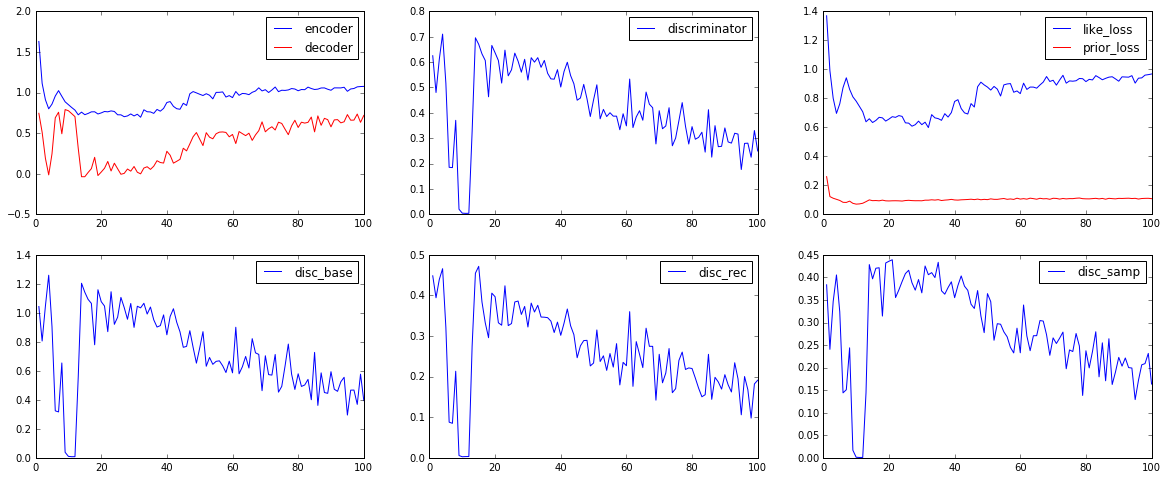

In [10]:
loss_data = vg.loss_buf
plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 1)
plt.plot(loss_data['epoch'], loss_data['enc_loss'], color="#0000FF", label="encoder")
plt.plot(loss_data['epoch'], loss_data['dec_loss'], color="#FF0000", label="decoder")
plt.legend(loc='upper right')
plt.subplot(2, 3, 2)
plt.plot(loss_data['epoch'], loss_data['dis_loss'], color="#0000FF", label="discriminator")
plt.legend(loc='upper right')
plt.subplot(2, 3, 3)
plt.plot(loss_data['epoch'], loss_data['like_loss'], color="#0000FF", label="like_loss")
plt.plot(loss_data['epoch'], loss_data['prior_loss'], color="#FF0000", label="prior_loss")
plt.legend(loc='upper right')
plt.subplot(2, 3, 4)
plt.plot(loss_data['epoch'], loss_data['L_base'], color="#0000FF", label="disc_base")
plt.legend(loc='upper right')
plt.subplot(2, 3, 5)
plt.plot(loss_data['epoch'], loss_data['L_rec'], color="#0000FF", label="disc_rec")
plt.legend(loc='upper right')
plt.subplot(2, 3, 6)
plt.plot(loss_data['epoch'], loss_data['L_p'], color="#0000FF", label="disc_samp")
plt.legend(loc='upper right')

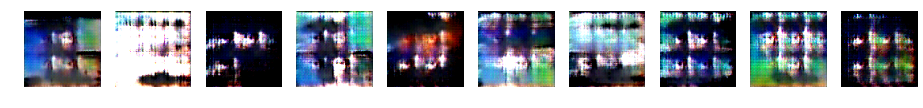

In [11]:
shape = 10, vg.latent_width
random_data = np.random.standard_normal(shape).astype('f')*3.
images = vg.inverse_transform(random_data, test=True)
plt.figure(figsize=(16,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


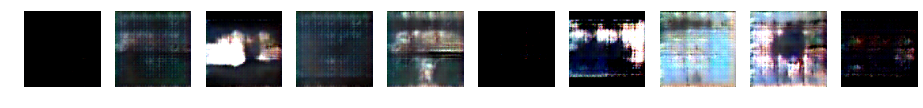

In [19]:
x_tmp = x_all[:10]
z_tmp = vg.transform(x_tmp, test=True)
img_tmp = vg.inverse_transform(z_tmp, test=True)

plt.figure(figsize=(16,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(img_tmp[i])
    plt.axis("off")
plt.show()

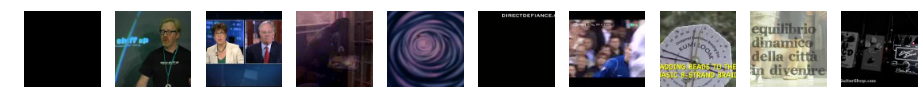

In [23]:
plt.figure(figsize=(16,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_tmp[i].transpose(1,2,0))
    plt.axis("off")
plt.show()